# Model

## Import des fichiers

In [411]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from functools import partial


#Modélisation
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV# the keys can be accessed with final_pipeline.get_params().keys()
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

#Text
import re

#Evaluation
from sklearn.metrics import f1_score, confusion_matrix


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#Tracking d'expérience
import mlflow
import mlflow.sklearn

## Utilisation du code du projet packagé

In [2]:
#Cette cellule permet d'appeler la version packagée du projet et d'en assurer le reload avant appel des fonctions
%load_ext autoreload
%autoreload 2

In [8]:
random_state=42

## Configuration de l'experiment MLFlow

In [77]:
mlflow.tracking.get_tracking_uri()

'/mnt/experiments'

## Chargement des données

In [41]:
df_merged = pd.read_parquet('/mnt/data/interim/df_merged.gzip')

On vire `NBSIN_TYPE1_AN2` => vu avec André : pb dans la variable qui est >=1

In [58]:
df_merged=df_merged.drop('NBSIN_TYPE1_AN2', axis=1)

In [218]:
df_train, df_val = train_test_split(df_merged, shuffle=False, test_size=0.2, random_state=random_state)

In [238]:
X_test=expo_test = pd.read_csv('/mnt/data/raw/expo_test.csv', encoding='utf8', sep=',' )

In [239]:
X_test=X_test.drop(['Unnamed: 0', 'NBSIN_TYPE1_AN2'], axis=1)

In [240]:
X_test

,EXPO,FORMULE,TYPE_RESIDENCE,TYPE_HABITATION,NB_PIECES,SITUATION_JURIDIQUE,NIVEAU_JURIDIQUE,VALEUR_DES_BIENS,OBJETS_DE_VALEUR,ZONIER,NBSIN_TYPE1_AN1,NBSIN_TYPE1_AN3,NBSIN_TYPE2_AN1,NBSIN_TYPE2_AN2,NBSIN_TYPE2_AN3,id,ANNEE
0,1.000000,CONFORT,PRINCIPALE,APPARTEMENT,4.0,LOCATAIRE,JUR1,35000.0,NIVEAU_1,B43,0,0,0,NaN,0,2,2019
1,0.468493,CONFORT,SECONDAIRE,MAISON,1.0,PROPRIO,JUR1,0.0,NIVEAU_1,C22,0,0,0,0.0,0,10,2019
2,0.852055,ESSENTIEL,PRINCIPALE,APPARTEMENT,0.0,PROPRIO,JUR1,0.0,NIVEAU_1,B32,0,0,0,0.0,0,18,2019
3,1.000000,CONFORT,PRINCIPALE,APPARTEMENT,3.0,LOCATAIRE,JUR1,50000.0,NIVEAU_1,C6,0,1,0,0.0,0,19,2019
4,0.079452,CONFORT,SECONDAIRE,MAISON,1.0,PROPRIO,JUR1,9000.0,NIVEAU_1,C6,0,0,0,0.0,0,39,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44344,1.000000,CONFORT,PRINCIPALE,APPARTEMENT,3.0,LOCATAIRE,JUR1,35000.0,NIVEAU_1,C5,0,0,0,0.0,0,499935,2019
44345,0.073973,CONFORT,SECONDAIRE,MAISON,2.0,LOCATAIRE,JUR1,0.0,NIVEAU_1,C6,0,0,0,0.0,0,499953,2019
44346,1.000000,ESSENTIEL,PRINCIPALE,MAISON,2.0,LOCATAIRE,JUR1,20000.0,NIVEAU_1,C13,0,0,0,0.0,0,499964,2019
44347,1.000000,CONFORT,PRINCIPALE,MAISON,2.0,LOCATAIRE,JUR1,9000.0,NIVEAU_1,C17,0,0,0,0.0,0,499969,2019


In [241]:
list(X_test)

['EXPO',
 'FORMULE',
 'TYPE_RESIDENCE',
 'TYPE_HABITATION',
 'NB_PIECES',
 'SITUATION_JURIDIQUE',
 'NIVEAU_JURIDIQUE',
 'VALEUR_DES_BIENS',
 'OBJETS_DE_VALEUR',
 'ZONIER',
 'NBSIN_TYPE1_AN1',
 'NBSIN_TYPE1_AN3',
 'NBSIN_TYPE2_AN1',
 'NBSIN_TYPE2_AN2',
 'NBSIN_TYPE2_AN3',
 'id',
 'ANNEE']

In [60]:
list(df_train)

['EXPO',
 'FORMULE',
 'TYPE_RESIDENCE',
 'TYPE_HABITATION',
 'NB_PIECES',
 'SITUATION_JURIDIQUE',
 'NIVEAU_JURIDIQUE',
 'VALEUR_DES_BIENS',
 'OBJETS_DE_VALEUR',
 'ZONIER',
 'NBSIN_TYPE1_AN1',
 'NBSIN_TYPE1_AN3',
 'NBSIN_TYPE2_AN1',
 'NBSIN_TYPE2_AN2',
 'NBSIN_TYPE2_AN3',
 'id',
 'ANNEE',
 'NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount']

In [225]:
y_train = df_train[['id','EXPO','NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount']]

In [226]:
y_train

,id,EXPO,NB,COUT,PurePremium,Frequency,AvgClaimAmount
0,5,1.000000,0.0,0.0,0.0,0.0,0.0
1,9,0.824657,0.0,0.0,0.0,0.0,0.0
2,11,1.000000,0.0,0.0,0.0,0.0,0.0
3,13,1.000000,0.0,0.0,0.0,0.0,0.0
4,14,1.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
124515,400345,1.000000,0.0,0.0,0.0,0.0,0.0
124516,400348,1.000000,0.0,0.0,0.0,0.0,0.0
124517,400350,0.273973,0.0,0.0,0.0,0.0,0.0
124518,400356,1.000000,0.0,0.0,0.0,0.0,0.0


In [227]:
y_train.describe()

,id,EXPO,NB,COUT,PurePremium,Frequency,AvgClaimAmount
count,124520.000000,124520.000000,124520.000000,124520.000000,124520.000000,124520.000000,124520.000000
mean,200071.902337,0.837586,0.017917,24.986664,32.123230,0.022580,24.359367
std,115728.477177,0.296708,0.136705,376.735988,749.479255,0.281951,369.059132
min,5.000000,0.002732,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99973.500000,0.816438,0.000000,0.000000,0.000000,0.000000,0.000000
50%,200222.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,300233.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,400357.000000,1.000000,3.000000,33089.120000,185244.917127,52.285749,33089.120000


In [228]:
X_train = df_train.drop(['NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount'], axis=1)

In [229]:
X_train

,EXPO,FORMULE,TYPE_RESIDENCE,TYPE_HABITATION,NB_PIECES,SITUATION_JURIDIQUE,NIVEAU_JURIDIQUE,VALEUR_DES_BIENS,OBJETS_DE_VALEUR,ZONIER,NBSIN_TYPE1_AN1,NBSIN_TYPE1_AN3,NBSIN_TYPE2_AN1,NBSIN_TYPE2_AN2,NBSIN_TYPE2_AN3,id,ANNEE
0,1.000000,MEDIUM,PRINCIPALE,APPARTEMENT,1.0,PROPRIO,JUR1,3500.0,NIVEAU_1,B40,0,0,0,0.0,0,5,2017
1,0.824657,CONFORT,PRINCIPALE,MAISON,NaN,PROPRIO,JUR1,0.0,NIVEAU_1,A11,0,0,0,0.0,0,9,2018
2,1.000000,ESSENTIEL,PRINCIPALE,APPARTEMENT,3.0,LOCATAIRE,JUR1,35000.0,NIVEAU_1,B32,0,0,0,0.0,0,11,2017
3,1.000000,ESSENTIEL,SECONDAIRE,MAISON,2.0,LOCATAIRE,JUR1,9000.0,NIVEAU_1,C24,0,0,0,0.0,0,13,2018
4,1.000000,ESSENTIEL,PRINCIPALE,MAISON,1.0,LOCATAIRE,JUR1,20000.0,NIVEAU_1,C9,0,0,0,0.0,0,14,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124515,1.000000,CONFORT,PRINCIPALE,MAISON,1.0,PROPRIO,JUR1,3500.0,NIVEAU_1,C20,1,0,0,0.0,0,400345,2018
124516,1.000000,MEDIUM,PRINCIPALE,MAISON,2.0,PROPRIO,JUR1,3500.0,NIVEAU_1,A2,0,0,0,0.0,0,400348,2017
124517,0.273973,CONFORT,SECONDAIRE,MAISON,1.0,PROPRIO,JUR1,3500.0,NIVEAU_1,C16,0,0,0,0.0,0,400350,2018
124518,1.000000,MEDIUM,PRINCIPALE,MAISON,2.0,LOCATAIRE,JUR1,3500.0,NIVEAU_1,C9,0,0,0,0.0,0,400356,2016


In [232]:
X_val = df_val.drop(['NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount'], axis=1)

In [233]:
y_val = df_val[['id','EXPO','NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount']]

In [234]:
y_val

,id,EXPO,NB,COUT,PurePremium,Frequency,AvgClaimAmount
124520,400364,0.775342,0.0,0.0,0.0,0.0,0.0
124521,400365,1.000000,0.0,0.0,0.0,0.0,0.0
124522,400366,1.000000,0.0,0.0,0.0,0.0,0.0
124523,400367,1.000000,0.0,0.0,0.0,0.0,0.0
124524,400368,1.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
155646,499986,0.680327,0.0,0.0,0.0,0.0,0.0
155647,499989,1.000000,0.0,0.0,0.0,0.0,0.0
155648,499991,0.569863,0.0,0.0,0.0,0.0,0.0
155649,499993,0.597260,0.0,0.0,0.0,0.0,0.0


## Création du code

In [164]:
def scores_to_dict(score_df):
    d = score_df['train'].to_dict()
    d1 = dict(zip([x+'_train_' for x in  list(d.keys())], list(d.values())))
    d = score_df['test'].to_dict()
    d2 = dict(zip([x+'_test' for x in  list(d.keys())], list(d.values())))
    d1.update(d2)
    return d1

### score_estimator

In [186]:
def score_estimator(
    estimator, X_train, X_test, df_train, df_test, target, weights,
    tweedie_powers=None, use_weights=True
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [(
            "mean Tweedie dev p={:.4f}".format(power),
            partial(mean_tweedie_deviance, power=power)
        ) for power in tweedie_powers]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y = df[target]
        if use_weights:
            _weights =  df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                if use_weights:
                    score = estimator.score(X, y, sample_weight=_weights)
                else:
                    score = estimator.score(X, y)
            else:
                if use_weights:
                    score = metric(y, y_pred, sample_weight=_weights)
                else:
                    score = metric(y, y_pred)

            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res

On commence par définir une fonction générique qui sera en capacité d'ajuster, optimiser et logger dans MLFlow les résultats de pipelines qui seront produits pour chaque essai

In [67]:
def random_state_params(pipe, seed):
    """Crée un dictionnaire constitué de tous les paramètres 'random_state' d'un pipe et leur assigne une valeur unique"""
    rs = re.findall(r"[a-zA-Z\_]+_random_state", ' '.join(list(pipe.get_params().keys())))
    rs=dict.fromkeys(rs, seed)
    return rs

### train pipeline

In [425]:
def trainPipelineMlFlow(mlf_XP, 
                        xp_name_iter, 
                        pipeline, 
                        X_train, y_train, X_test, y_test, 
                        target_col='Frequency', 
                        weight_col='exposure', 
                        use_weights=False, 
                        fixed_params={}, 
                        opti=False, iterable_params={}):
    """
    Fonction générique permettant d'entrainer et d'optimiser un pipeline sklearn
    Les paramètres et résultats sont stockés dans MLFlow
    """
  
    mlflow.set_experiment(mlf_XP)

    with mlflow.start_run(run_name=xp_name_iter):
        
        start_time = time.monotonic()  
        
        warnings.filterwarnings("ignore")
        
        # fit pipeline
        pipeline.set_params(**fixed_params)
        if not opti:
            search = pipeline
        else:
            search = RandomizedSearchCV(pipeline, iterable_params)
        
        if use_weights:
            search.fit(X_train, y_train[target_col], sample_weight=X_train[weight_col])
        else:
            search.fit(X_train, y_train[target_col])
                
        # get params
        params_to_log = fixed_params #select initial params
        if opti:
            params_to_log.update(search.best_params_) #update for optimal solution
        mlflow.log_params(params_to_log)
        
        # Evaluate metrics
        y_pred=search.predict(X_test)
        score = score_estimator(estimator=search, 
                                         X_train=X_train, 
                                         X_test=X_test, 
                                         df_train=y_train, 
                                         df_test=y_test, 
                                         target=target_col, 
                                         weights=weight_col,
                                         use_weights=use_weights)
        
        # Print out metrics
        print(xp_name_iter)
        print("params:" % params_to_log)
        print(score)

        mlflow.log_metrics(scores_to_dict(score))
        mlflow.sklearn.log_model(pipeline, xp_name_iter)
        
        end_time = time.monotonic()
        elapsed_time = timedelta(seconds=end_time - start_time)
        print('elapsed time :', elapsed_time)
        mlflow.set_tag(key="elapsed_time", value=elapsed_time)   
        
    return search
        

La cellule suivante permet de créer des étapes de sélection de colonnes dans les Data Frame en entrée

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

## Essai pipeline

In [70]:
list(X_train)

['EXPO',
 'FORMULE',
 'TYPE_RESIDENCE',
 'TYPE_HABITATION',
 'NB_PIECES',
 'SITUATION_JURIDIQUE',
 'NIVEAU_JURIDIQUE',
 'VALEUR_DES_BIENS',
 'OBJETS_DE_VALEUR',
 'ZONIER',
 'NBSIN_TYPE1_AN1',
 'NBSIN_TYPE1_AN3',
 'NBSIN_TYPE2_AN1',
 'NBSIN_TYPE2_AN2',
 'NBSIN_TYPE2_AN3',
 'id',
 'ANNEE']

In [14]:

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

In [119]:


column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VALEUR_DES_BIENS"]),
        ("onehot_categorical", OneHotEncoder(),
            ["FORMULE", "TYPE_RESIDENCE", "TYPE_RESIDENCE", "NB_PIECES", "SITUATION_JURIDIQUE",'NIVEAU_JURIDIQUE','OBJETS_DE_VALEUR', 'ZONIER', 'NBSIN_TYPE1_AN1', 'NBSIN_TYPE1_AN3', 'NBSIN_TYPE2_AN1', 'NBSIN_TYPE2_AN2', 'NBSIN_TYPE2_AN3']),
        ("passthrough_numeric", "passthrough",
            ["NB_PIECES"]),
        ("log_scaled_numeric", log_scale_transformer,
            [])
    ],
    remainder="drop",
)




inspiration : https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f

In [136]:
# Define categorical pipeline
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', MinMaxScaler())])

num_pipe_binned = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', KBinsDiscretizer(n_bins=10))])

num_pipe_log = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', KBinsDiscretizer(n_bins=10))])


# Fit column transformer to training data
preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, ["FORMULE", "TYPE_RESIDENCE", "SITUATION_JURIDIQUE",'NIVEAU_JURIDIQUE','OBJETS_DE_VALEUR', 'ZONIER', 'NBSIN_TYPE1_AN1', 'NBSIN_TYPE1_AN3', 'NBSIN_TYPE2_AN1',  'NBSIN_TYPE2_AN3']),
                                               ('num_binned', num_pipe_binned, ["VALEUR_DES_BIENS"])],remainder='drop')

In [166]:
pipeline_GLM = Pipeline(
    steps=[
#        ('na', SimpleImputer(strategy='median')),
#        ('preprocess', column_trans), #Sélection de la colonne à transformer (corpus)
        ('preprocess', preprocessor), 
        ("glm", PoissonRegressor(max_iter=400))
    ]
)

In [167]:
list(pipeline_GLM.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocess',
 'glm',
 'preprocess__n_jobs',
 'preprocess__remainder',
 'preprocess__sparse_threshold',
 'preprocess__transformer_weights',
 'preprocess__transformers',
 'preprocess__verbose',
 'preprocess__cat',
 'preprocess__num_binned',
 'preprocess__cat__memory',
 'preprocess__cat__steps',
 'preprocess__cat__verbose',
 'preprocess__cat__imputer',
 'preprocess__cat__encoder',
 'preprocess__cat__imputer__add_indicator',
 'preprocess__cat__imputer__copy',
 'preprocess__cat__imputer__fill_value',
 'preprocess__cat__imputer__missing_values',
 'preprocess__cat__imputer__strategy',
 'preprocess__cat__imputer__verbose',
 'preprocess__cat__encoder__categories',
 'preprocess__cat__encoder__drop',
 'preprocess__cat__encoder__dtype',
 'preprocess__cat__encoder__handle_unknown',
 'preprocess__cat__encoder__sparse',
 'preprocess__num_binned__memory',
 'preprocess__num_binned__steps',
 'preprocess__num_binned__verbose',
 'preprocess__num_binned__imputer',
 'prepr

In [150]:
y_test['EXPO']

124520    0.775342
124521    1.000000
124522    1.000000
124523    1.000000
124524    1.000000
            ...   
155646    0.680327
155647    1.000000
155648    0.569863
155649    0.597260
155650    1.000000
Name: EXPO, Length: 31131, dtype: float64

In [165]:
trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-GLM", 
    pipeline=pipeline_GLM, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test, 
    target_col='PurePremium', 
    weight_col='EXPO', 
    fixed_params=random_state_params(pipeline_GLM,42))

Ini-GLM
params:
subset                    train         test
metric                                      
D² explained             0.0579       0.0294
mean abs. error         61.3388      59.7598
mean squared error  223222.3396  218523.5348
elapsed time : 0:00:11.605138


In [86]:
mlflow.end_run()

In [102]:
X_train.isna().sum()

EXPO                       0
FORMULE                    0
TYPE_RESIDENCE             0
TYPE_HABITATION            0
NB_PIECES               7458
SITUATION_JURIDIQUE        0
NIVEAU_JURIDIQUE           0
VALEUR_DES_BIENS           0
OBJETS_DE_VALEUR           0
ZONIER                     0
NBSIN_TYPE1_AN1            0
NBSIN_TYPE1_AN3            0
NBSIN_TYPE2_AN1            0
NBSIN_TYPE2_AN2        13558
NBSIN_TYPE2_AN3            0
id                         0
ANNEE                      0
dtype: int64

In [168]:
trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-GLM_alpha1e-4", 
    pipeline=pipeline_GLM, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test, 
    target_col='PurePremium', 
    weight_col='EXPO', 
    fixed_params={'glm__alpha':1e-4})

Ini-GLM_alpha1e-4
params:
subset                   train         test
metric                                     
D² explained             0.058       0.0280
mean abs. error         61.324      59.7487
mean squared error  223221.747  218525.5891
elapsed time : 0:00:11.671008


## Modélisation prime pure par Tweedie

In [169]:
pipeline_Tweedie = Pipeline(
    steps=[
#        ('na', SimpleImputer(strategy='median')),
#        ('preprocess', column_trans), #Sélection de la colonne à transformer (corpus)
        ('preprocess', preprocessor), 
        ("Tweedie", TweedieRegressor(power=1.9, alpha=.1, max_iter=10000))
    ]
)

In [189]:
trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-Tweedie", 
    pipeline=pipeline_Tweedie, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test, 
    target_col='PurePremium',
    use_weights=False)

Ini-Tweedie
params:
subset                    train         test
metric                                      
D² explained             0.0223       0.0171
mean abs. error         60.0233      61.5289
mean squared error  561186.4676  526904.9401
elapsed time : 0:00:02.694281


In [178]:
class PipelineSW(Pipeline):
    def fit(self, X, y, sample_weight=None):
        """Fit and pass sample weights only to the last step"""
        if sample_weight is not None:
            kwargs = {self.steps[-1][0] + '__sample_weight': sample_weight}
        else:
            kwargs = {}
        return super().fit(X, y, **kwargs)

In [179]:
pipeline_Tweedie_SW = PipelineSW(
    steps=[
#        ('na', SimpleImputer(strategy='median')),
#        ('preprocess', column_trans), #Sélection de la colonne à transformer (corpus)
        ('preprocess', preprocessor), 
        ("Tweedie", TweedieRegressor(power=1.9, alpha=.1, max_iter=10000))
    ]
)

In [180]:
list(pipeline_Tweedie_SW.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocess',
 'Tweedie',
 'preprocess__n_jobs',
 'preprocess__remainder',
 'preprocess__sparse_threshold',
 'preprocess__transformer_weights',
 'preprocess__transformers',
 'preprocess__verbose',
 'preprocess__cat',
 'preprocess__num_binned',
 'preprocess__cat__memory',
 'preprocess__cat__steps',
 'preprocess__cat__verbose',
 'preprocess__cat__imputer',
 'preprocess__cat__encoder',
 'preprocess__cat__imputer__add_indicator',
 'preprocess__cat__imputer__copy',
 'preprocess__cat__imputer__fill_value',
 'preprocess__cat__imputer__missing_values',
 'preprocess__cat__imputer__strategy',
 'preprocess__cat__imputer__verbose',
 'preprocess__cat__encoder__categories',
 'preprocess__cat__encoder__drop',
 'preprocess__cat__encoder__dtype',
 'preprocess__cat__encoder__handle_unknown',
 'preprocess__cat__encoder__sparse',
 'preprocess__num_binned__memory',
 'preprocess__num_binned__steps',
 'preprocess__num_binned__verbose',
 'preprocess__num_binned__imputer',
 'p

In [283]:
model = trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-Tweedie-sampleWeight", 
    pipeline=pipeline_Tweedie_SW, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_val, 
    y_test=y_val, 
    target_col='PurePremium', 
    weight_col='EXPO',
    use_weights=True)

Ini-Tweedie-sampleWeight
params:
subset                    train         test
metric                                      
D² explained             0.0195       0.0156
mean abs. error         56.0804      53.9778
mean squared error  223595.3580  218201.8055
elapsed time : 0:00:02.420781


### Opti Tweedie

In [390]:
params = {
    'Tweedie__power': 0
}


In [385]:
model = trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-TweedieSW-optiPower-0", 
    pipeline=pipeline_Tweedie_SW, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_val, 
    y_test=y_val, 
    target_col='PurePremium', 
    weight_col='EXPO',
    use_weights=True,
    fixed_params=params
)

Ini-TweedieSW-optiPower-0
params:
subset                    train         test
metric                                      
D² explained             0.0017       0.0014
mean abs. error         58.2854      56.1170
mean squared error  223634.9062  218239.2274
elapsed time : 0:00:02.702185


In [391]:
params = {
    'Tweedie__power': 1
}


In [392]:
model = trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-TweedieSW-optiPower-1", 
    pipeline=pipeline_Tweedie_SW, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_val, 
    y_test=y_val, 
    target_col='PurePremium', 
    weight_col='EXPO',
    use_weights=True,
    fixed_params=params
)

Ini-TweedieSW-optiPower-1
params:
subset                    train         test
metric                                      
D² explained             0.0619       0.0441
mean abs. error         58.0435      56.1713
mean squared error  223267.8422  218175.6337
elapsed time : 0:00:04.353207


In [393]:
params = {
    'Tweedie__power': 1.5
}


In [394]:
model = trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-TweedieSW-optiPower-1.5", 
    pipeline=pipeline_Tweedie_SW, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_val, 
    y_test=y_val, 
    target_col='PurePremium', 
    weight_col='EXPO',
    use_weights=True,
    fixed_params=params
)

Ini-TweedieSW-optiPower-1.5
params:
subset                    train         test
metric                                      
D² explained             0.0715       0.0555
mean abs. error         57.0900      55.0937
mean squared error  223453.8596  218143.4718
elapsed time : 0:00:03.113444


In [404]:
params = {
    'Tweedie__power': 1.75
}


In [405]:
model = trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-TweedieSW-optiPower-1.75", 
    pipeline=pipeline_Tweedie_SW, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_val, 
    y_test=y_val, 
    target_col='PurePremium', 
    weight_col='EXPO',
    use_weights=True,
    fixed_params=params
)

Ini-TweedieSW-optiPower-1.75
params:
subset                    train         test
metric                                      
D² explained             0.0447       0.0355
mean abs. error         56.4804      54.4151
mean squared error  223542.1760  218171.6343
elapsed time : 0:00:02.757547


In [402]:
params = {
    'Tweedie__power': 1.99
}


In [403]:
params = {
    'Tweedie__power': 1.99
}

model = trainPipelineMlFlow(
    mlf_XP = 'Init',
    xp_name_iter= "Ini-TweedieSW-optiPower-1.99", 
    pipeline=pipeline_Tweedie_SW, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_val, 
    y_test=y_val, 
    target_col='PurePremium', 
    weight_col='EXPO',
    use_weights=True,
    fixed_params=params
)

Ini-TweedieSW-optiPower-1.99
params:
subset                    train         test
metric                                      
D² explained             0.0020       0.0016
mean abs. error         55.8333      53.7116
mean squared error  223628.7999  218224.7150
elapsed time : 0:00:02.527945


## Enseignements

La masse en 0 est beaucoup trop fort (98,3%) pour permettre une modélisation classique. On bascule sur l'option 2 : I(N>0)*E[S]

### On essaie de savoir si Tweedie peut déjà aider sur les sinistres

In [409]:
params = {
    'Tweedie__power': 1.99
}

model = trainPipelineMlFlow(
    mlf_XP = 'Charge>0',
    xp_name_iter= "Chg-TweedieSW-optiPower-1.99", 
    pipeline=pipeline_Tweedie_SW, 
    X_train=X_train[y_train['NB']>0], 
    y_train=y_train[y_train['NB']>0], 
    X_test=X_val[y_val['NB']>0], 
    y_test=y_val[y_val['NB']>0], 
    target_col='PurePremium', 
    weight_col='EXPO',
    use_weights=True,
    fixed_params=params
)

INFO: 'Charge>0' does not exist. Creating a new experiment
Chg-TweedieSW-optiPower-1.99
params:
subset                     train          test
metric                                        
D² explained        4.750000e-02  6.900000e-03
mean abs. error     1.494872e+03  1.495566e+03
mean squared error  9.068450e+06  9.489292e+06
elapsed time : 0:00:00.135901


### On passe à RandomForest

In [418]:
# Define categorical pipeline
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', MinMaxScaler())])

num_pipe_binned = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', KBinsDiscretizer(n_bins=10))])

num_pipe_log = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', KBinsDiscretizer(n_bins=10))])


# Fit column transformer to training data
preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, ["FORMULE", "TYPE_RESIDENCE", "SITUATION_JURIDIQUE",'NIVEAU_JURIDIQUE','OBJETS_DE_VALEUR', 'ZONIER', 'NBSIN_TYPE1_AN1', 'NBSIN_TYPE1_AN3', 'NBSIN_TYPE2_AN1',  'NBSIN_TYPE2_AN3']),
                                               ('num_binned', num_pipe_binned, ["VALEUR_DES_BIENS"])],remainder='drop')

In [422]:
pipeline_RFR = PipelineSW(
    steps=[
        ('preprocess', preprocessor), 
        ('rf', RandomForestRegressor(random_state=42, n_estimators=100))
    ]
)

In [423]:
list(pipeline_RFR.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocess',
 'rf',
 'preprocess__n_jobs',
 'preprocess__remainder',
 'preprocess__sparse_threshold',
 'preprocess__transformer_weights',
 'preprocess__transformers',
 'preprocess__verbose',
 'preprocess__cat',
 'preprocess__num_binned',
 'preprocess__cat__memory',
 'preprocess__cat__steps',
 'preprocess__cat__verbose',
 'preprocess__cat__imputer',
 'preprocess__cat__encoder',
 'preprocess__cat__imputer__add_indicator',
 'preprocess__cat__imputer__copy',
 'preprocess__cat__imputer__fill_value',
 'preprocess__cat__imputer__missing_values',
 'preprocess__cat__imputer__strategy',
 'preprocess__cat__imputer__verbose',
 'preprocess__cat__encoder__categories',
 'preprocess__cat__encoder__drop',
 'preprocess__cat__encoder__dtype',
 'preprocess__cat__encoder__handle_unknown',
 'preprocess__cat__encoder__sparse',
 'preprocess__num_binned__memory',
 'preprocess__num_binned__steps',
 'preprocess__num_binned__verbose',
 'preprocess__num_binned__imputer',
 'prepro

In [426]:
params = {
    'Tweedie__power': 1.99
}

model = trainPipelineMlFlow(
    mlf_XP = 'Charge>0',
    xp_name_iter= "Chg-RFR", 
    pipeline=pipeline_RFR, 
    X_train=X_train[y_train['NB']>0], 
    y_train=y_train[y_train['NB']>0], 
    X_test=X_val[y_val['NB']>0], 
    y_test=y_val[y_val['NB']>0], 
    target_col='PurePremium', 
    weight_col='EXPO',
    use_weights=True
)

Chg-RFR
params:
subset                     train          test
metric                                        
D² explained        5.323000e-01 -3.428000e-01
mean abs. error     1.023581e+03  1.764505e+03
mean squared error  4.347053e+06  1.278746e+07
elapsed time : 0:00:01.130057


### Soumission

In [237]:
list(X_test)

['EXPO',
 'FORMULE',
 'TYPE_RESIDENCE',
 'TYPE_HABITATION',
 'NB_PIECES',
 'SITUATION_JURIDIQUE',
 'NIVEAU_JURIDIQUE',
 'VALEUR_DES_BIENS',
 'OBJETS_DE_VALEUR',
 'ZONIER',
 'NBSIN_TYPE1_AN1',
 'NBSIN_TYPE1_AN3',
 'NBSIN_TYPE2_AN1',
 'NBSIN_TYPE2_AN2',
 'NBSIN_TYPE2_AN3',
 'id',
 'ANNEE',
 'prime']

In [242]:
logged_model = '/mnt/experiments/1/736cb17cb7bf40fa8c1cea60dc82c37c/artifacts/Ini-Tweedie-sampleWeight'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
primes = loaded_model.predict(X_test)

In [243]:
pd.DataFrame(primes).describe()

,0
count,44349.000000
mean,27.515573
std,14.914503
min,6.978850
25%,15.603500
50%,24.589727
75%,35.228699
max,151.872219


In [259]:
list(X_test)

['EXPO',
 'FORMULE',
 'TYPE_RESIDENCE',
 'TYPE_HABITATION',
 'NB_PIECES',
 'SITUATION_JURIDIQUE',
 'NIVEAU_JURIDIQUE',
 'VALEUR_DES_BIENS',
 'OBJETS_DE_VALEUR',
 'ZONIER',
 'NBSIN_TYPE1_AN1',
 'NBSIN_TYPE1_AN3',
 'NBSIN_TYPE2_AN1',
 'NBSIN_TYPE2_AN2',
 'NBSIN_TYPE2_AN3',
 'id',
 'ANNEE']

In [278]:
def cree_soumission(X_test, model, nom_fichier_csv='primes2019_soumission.csv'):

    soumission = X_test.copy()
    soumission['prime']=loaded_model.predict(X_test)
    soumission=soumission[['id','prime']]
    
    #soumission.rename({'id':'"id"', 'prime':'"prime"'})
    
    soumission.to_csv('/mnt/data/processed/'+nom_fichier_csv, sep=';', decimal=',', encoding='utf-8', index=False, quotechar='"')

    return soumission
    

In [280]:
cree_soumission(X_test, loaded_model, 'primes2019_v1.csv')

,id,prime
0,2,36.243205
1,10,9.463946
2,18,11.637120
3,19,41.469083
4,39,12.342437
...,...,...
44344,499935,44.801261
44345,499953,13.200199
44346,499964,30.766823
44347,499969,27.529226


In [248]:
X_test.shape

(44349, 18)

# Analyse des modèles

In [326]:
def plot_obs_pred(df, feature, weight, observed, predicted, y_label=None,
                  title_train_test=None, ax=None, fill_legend=False, output_df=False):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )
    df_=df_.reset_index()

  
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
#        px.bar(x=df_[feature],y=df_[weight]),
        go.Bar(x=df_[feature], y=df_[weight], name="exposure"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=df_[feature], y=df_["observed"], mode='lines', name="observed"),
        secondary_y=True,
    )
    
    fig.add_trace(
        go.Scatter(x=df_[feature], y=df_["predicted"], mode='lines', name="predicted"),
        secondary_y=True,
    )
    

    # Add figure title
    fig.update_layout(
        title_text="Valeurs observées vs prédites par "+feature + " sur " + title_train_test
    )

    # Set x-axis title
    fig.update_xaxes(title_text=feature)

    # Set y-axes titles
    fig.update_yaxes(title_text="exposure", secondary_y=False)
    fig.update_yaxes(title_text="value", secondary_y=True)

    fig.show()
    
    if output_df:
        return df_
    
    

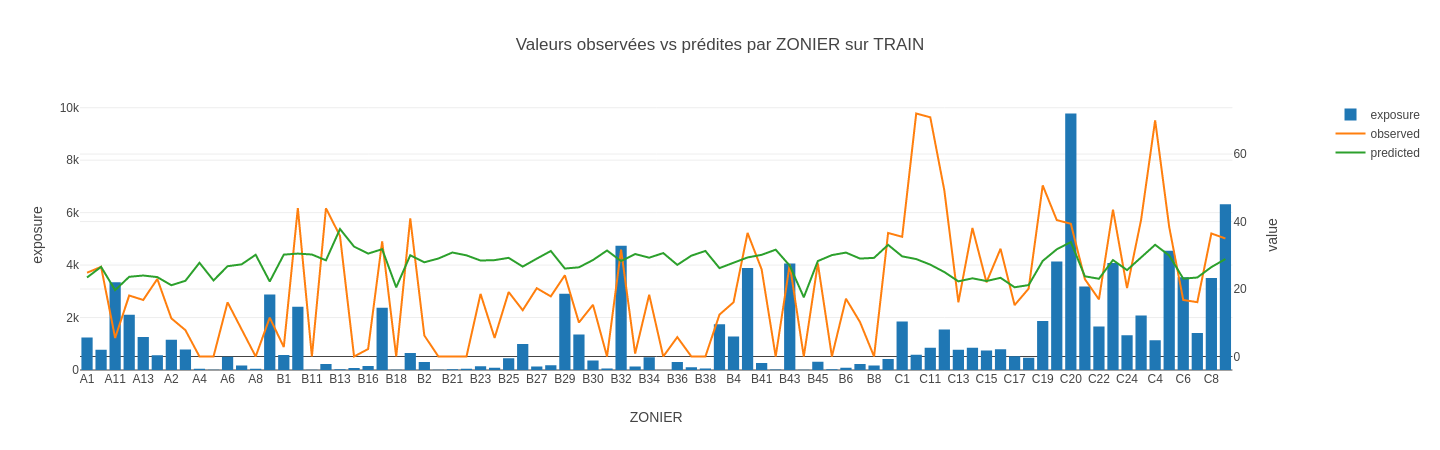

,ZONIER,EXPO,observed,predicted
0,A1,1234.740203,24.827733,23.411114
1,A10,769.034345,26.574470,26.571576
2,A11,3347.112469,5.503565,19.671340
3,A12,2107.006323,18.076310,23.620616
4,A13,1256.151162,16.753867,24.002683
...,...,...,...,...
77,C5,4545.710962,38.407627,29.940347
78,C6,3533.386157,16.759510,23.073554
79,C7,1409.578614,16.100081,23.411096
80,C8,3510.895410,36.463020,26.496979


In [328]:
plot_obs_pred(
    df=df_train,
    feature="ZONIER",
    weight="EXPO",
    observed="PurePremium",
    predicted=loaded_model.predict(X_train),
    y_label="Pure Premium",
    title_train_test="TRAIN",
    output_df=True
)

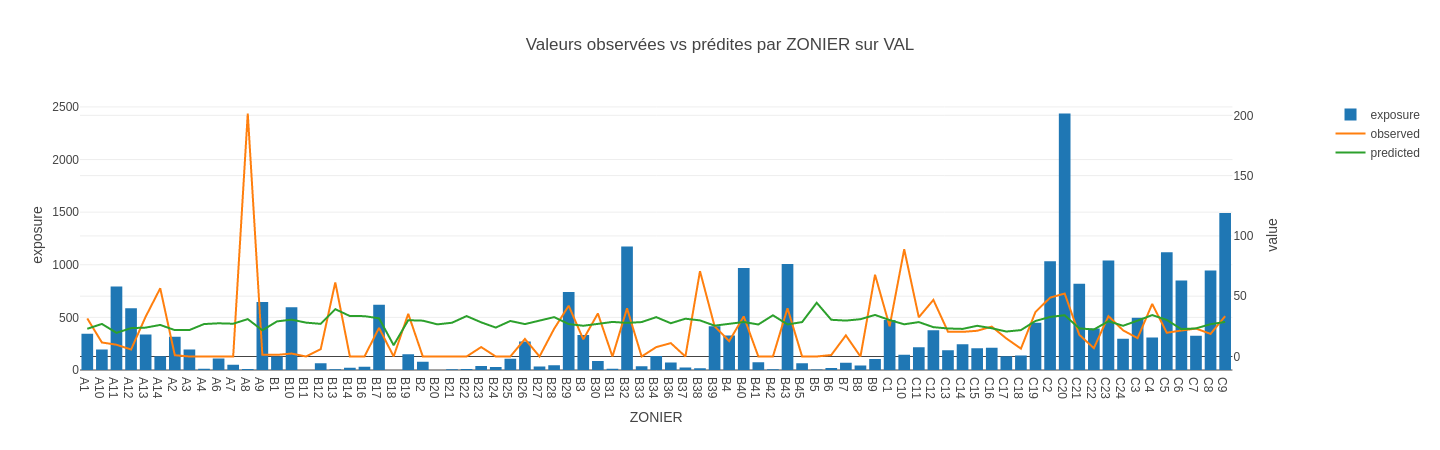

,ZONIER,EXPO,observed,predicted
0,A1,344.411467,31.573310,22.999894
1,A10,194.005524,11.642864,27.009967
2,A11,793.290423,9.760965,19.643193
3,A12,587.430674,5.778776,23.517295
4,A13,337.455798,32.996618,23.958773
...,...,...,...,...
74,C5,1119.508477,19.703602,30.316255
75,C6,849.604234,21.549610,22.666188
76,C7,326.478680,23.177226,23.335800
77,C8,944.972472,18.747287,26.785168


In [329]:
plot_obs_pred(
    df=df_val,
    feature="ZONIER",
    weight="EXPO",
    observed="PurePremium",
    predicted=loaded_model.predict(X_val),
    y_label="Pure Premium",
    title_train_test="VAL",
    output_df=True
)

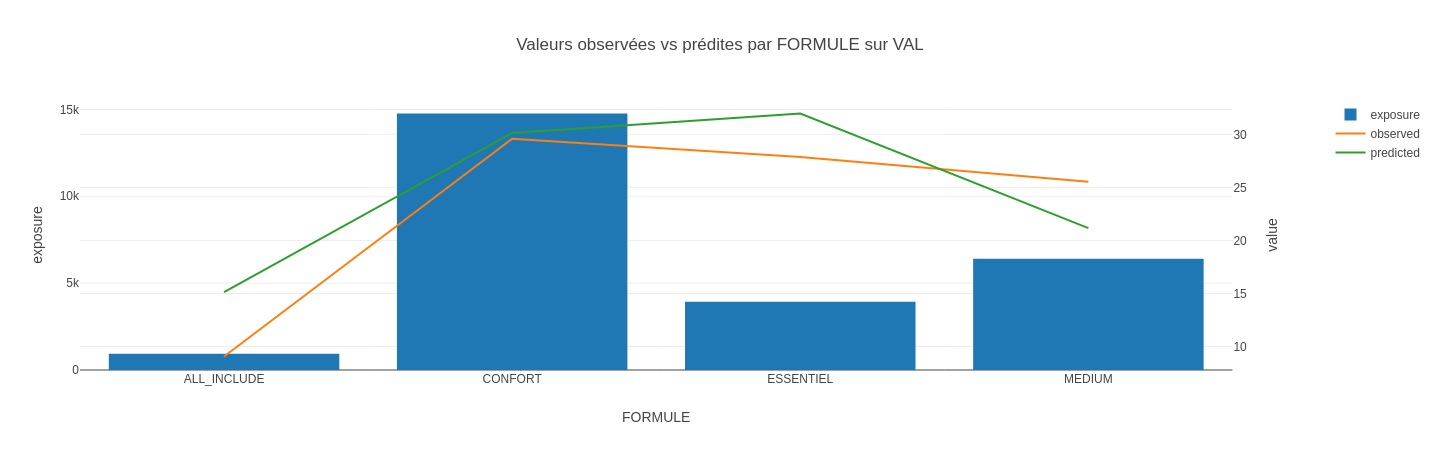

,FORMULE,EXPO,observed,predicted
0,ALL_INCLUDE,928.212298,9.065534,15.130560
1,CONFORT,14764.709199,29.587882,30.132981
2,ESSENTIEL,3927.093421,27.868171,31.959374
3,MEDIUM,6406.917588,25.540199,21.157534


In [330]:
plot_obs_pred(
    df=df_val,
    feature="FORMULE",
    weight="EXPO",
    observed="PurePremium",
    predicted=loaded_model.predict(X_val),
    y_label="Pure Premium",
    title_train_test="VAL",
    output_df=True
)

In [349]:
def plot_residuals(df, observed, predicted, y_label=None,
                  title_train_test=None, ax=None, fill_legend=False, output_df=False):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [observed]].copy()
    df_["observed"] = df[observed]
    df_["predicted"] = predicted
    df_=df_.sort_values(by=['predicted'])
  
  
    fig = make_subplots(specs=[[{"secondary_y": True}]])

  
    fig.add_trace(
        go.Scatter( x=df_['predicted'], y=df_["observed"]- df_["predicted"], mode='markers', name="difference"),
        secondary_y=True,
    )
    
    

    # Add figure title
    fig.update_layout(
        title_text="Valeurs observées - prédites par valeur prédite croissante"
    )

    # Set x-axis title
    fig.update_xaxes(title_text="predicted")

    # Set y-axes titles
    fig.update_yaxes(title_text="exposure", secondary_y=False)
    fig.update_yaxes(title_text="value", secondary_y=True)

    fig.show()
    
    if output_df:
        return df_
    

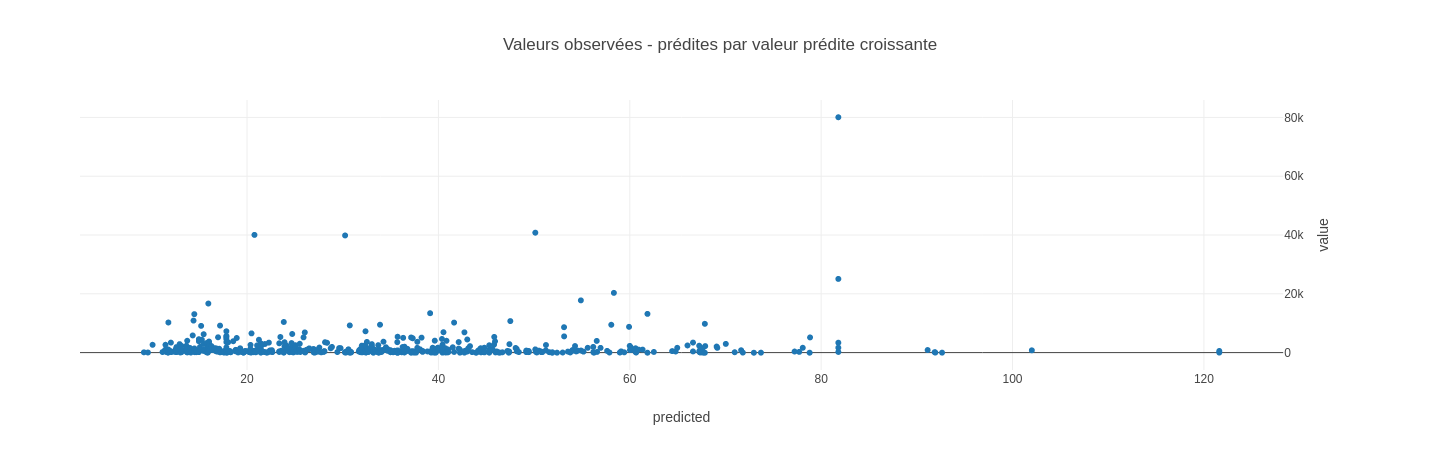

,PurePremium,observed,predicted
124670,102.751793,102.751793,9.222658
152732,43.182806,43.182806,9.646584
150908,2660.850173,2660.850173,10.127799
149018,203.210000,203.210000,11.169247
126896,950.620000,950.620000,11.443113
...,...,...,...
148178,102.180000,102.180000,91.931233
128547,75.660000,75.660000,92.633758
142812,871.610000,871.610000,102.018603
133994,129.770000,129.770000,121.607341


In [353]:
plot_residuals(
    df=df_val[df_val["PurePremium"]>0],
    observed="PurePremium",
    predicted=loaded_model.predict(X_val[df_val["PurePremium"]>0]),
    y_label="Pure Premium",
    title_train_test="VAL",
    output_df=True
)

In [352]:
list(X_val)

['EXPO',
 'FORMULE',
 'TYPE_RESIDENCE',
 'TYPE_HABITATION',
 'NB_PIECES',
 'SITUATION_JURIDIQUE',
 'NIVEAU_JURIDIQUE',
 'VALEUR_DES_BIENS',
 'OBJETS_DE_VALEUR',
 'ZONIER',
 'NBSIN_TYPE1_AN1',
 'NBSIN_TYPE1_AN3',
 'NBSIN_TYPE2_AN1',
 'NBSIN_TYPE2_AN2',
 'NBSIN_TYPE2_AN3',
 'id',
 'ANNEE']

In [ ]:
def plot_lift(df, weight, observed, predicted, y_label=None,
                  title_train_test=None, ax=None, fill_legend=False, output_df=False):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )
    df_=df_.reset_index()
    df_=df_.sort_values(by=['predicted'])
  
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
#        px.bar(x=df_[feature],y=df_[weight]),
        go.Bar(x=df_[feature], y=df_[weight], name="exposure"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=df_[feature], y=df_["observed"], mode='lines', name="observed"),
        secondary_y=True,
    )
    
    fig.add_trace(
        go.Scatter(x=df_[feature], y=df_["predicted"], mode='lines', name="predicted"),
        secondary_y=True,
    )
    

    # Add figure title
    fig.update_layout(
        title_text="Valeurs observées vs prédites par "+feature + " sur " + title_train_test
    )

    # Set x-axis title
    fig.update_xaxes(title_text=feature)

    # Set y-axes titles
    fig.update_yaxes(title_text="exposure", secondary_y=False)
    fig.update_yaxes(title_text="value", secondary_y=True)

    fig.show()
    
    if output_df:
        return df_
    
    

In [360]:
bins = KBinsDiscretizer(n_bins=10)
test =bins.fit_transform(df_val[['PurePremium']])

In [361]:
essai=df_val[['PurePremium']].copy()

In [367]:
essai['bins'] = test.todense()

In [363]:
essai

,PurePremium,bins
124520,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
124521,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
124522,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
124523,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
124524,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
...,...,...
155646,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
155647,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
155648,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
155649,0.0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."


In [377]:
essai=df_val[['EXPO','PurePremium']].copy()
essai['predicted']= loaded_model.predict(X_val)
#essai['bins']= pd.qcut(essai['PurePremium'],q=5)
essai.describe()

,EXPO,PurePremium,predicted
count,31131.000000,31131.000000,31131.000000
mean,0.836046,33.492690,26.667966
std,0.297231,726.362066,14.622175
min,0.002732,0.000000,6.846720
25%,0.797260,0.000000,15.246360
50%,1.000000,0.000000,22.722871
75%,1.000000,0.000000,34.024981
max,1.000000,80150.093324,146.442645


In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=test, y=df_[weight], name="exposure"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_[feature], y=df_["observed"], mode='lines', name="observed"),
    secondary_y=True,
)
    

In [374]:
pr = ProfileReport(df_train).to_file(output_file='df_train.html')

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

** ATTENTION ** : il n'y a que 1,7% de sinistres!!!

In [376]:
df_train[['COUT']].describe()

,COUT
count,124520.000000
mean,24.986664
std,376.735988
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,33089.120000
